In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, regularizers
from google.colab import drive

In [ ]:
# Veri yolu
drive.mount('/content/drive')

# Datasetin bulunduğu yolu belirleyelim
dataset_path = "/content/drive/MyDrive/dataset"

# Train, Validation ve Test dizinlerini oluştur
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "validation")
test_dir = os.path.join(dataset_path, "test")

# Parametreler
img_size = (224, 224)  # Görsellerin boyutu
batch_size = 64  # Batch boyutu

# Train dataset
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

# Validation dataset
val_ds = image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

# Test dataset
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)


Mounted at /content/drive
Found 6739 files belonging to 3 classes.
Found 1685 files belonging to 3 classes.
Found 2106 files belonging to 3 classes.


In [ ]:
# Modeli oluştur
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),  # Normalizasyon

    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.4),  # Dropout artırıldı

    layers.Dense(3, activation='softmax')  # 3 sınıf olduğu için
])

# Modeli derle (Learning Rate düşürüldü)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model özeti
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,784,771 (98.36 MB)

 Trainable params: 25,784,579 (98.36 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [ ]:
epochs = 100  # Maksimum epoch sayısı

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]  # EarlyStopping ekliyoruz
)


Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.4765 - loss: 17.9945 - val_accuracy: 0.4944 - val_loss: 5.0190
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.6914 - loss: 4.1908 - val_accuracy: 0.6190 - val_loss: 3.4775
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.7277 - loss: 2.9051 - val_accuracy: 0.6843 - val_loss: 2.6859
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.7538 - loss: 2.2440 - val_accuracy: 0.7116 - val_loss: 2.2033
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.7504 - loss: 1.9118 - val_accuracy: 0.7104 - val_loss: 1.8494
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.7803 - loss: 1.6200 - val_accuracy: 0.7442 - val_loss: 1.6000
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.7843 - loss: 1.4643 - val_accuracy: 0.7715 - val_loss: 1.4310
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.8022 - loss: 1

In [ ]:
model.save("waste_classification_model.h5")

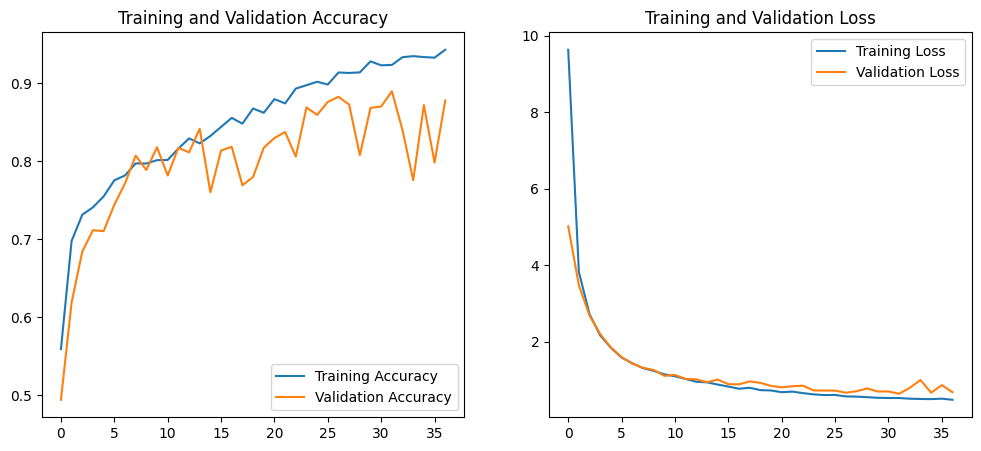

In [ ]:
# Loss ve Accuracy Grafikleri
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy Grafiği
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    # Loss Grafiği
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")

    plt.show()

# Grafikleri çiz
plot_history(history)


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9124 - loss: 0.5460
Test Accuracy: 0.8984


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━

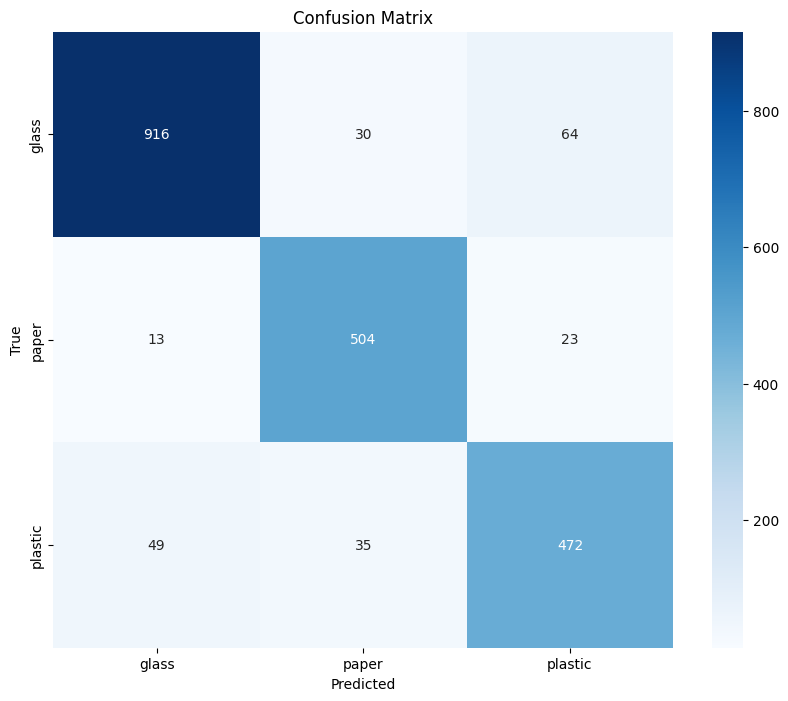

Classification Report:
              precision    recall  f1-score   support

       glass       0.94      0.91      0.92      1010
       paper       0.89      0.93      0.91       540
     plastic       0.84      0.85      0.85       556

    accuracy                           0.90      2106
   macro avg       0.89      0.90      0.89      2106
weighted avg       0.90      0.90      0.90      2106



In [ ]:

# Test veri kümesi üzerinde tahminler
predictions = []
labels = []

for images, label in test_ds:
    pred = model.predict(images)
    pred_classes = np.argmax(pred, axis=1)
    predictions.extend(pred_classes)
    labels.extend(label.numpy())

# Confusion matrix oluştur
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(labels, predictions)
class_names = test_ds.class_names

# Confusion matrix grafiği
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Sınıflandırma raporu
print("Classification Report:")
print(classification_report(labels, predictions, target_names=class_names))